### Mounting your google drive on Colab Noetebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
## remplazá 'workshopml'
# por el nombre que le hayas puesto a esa carpeta en drive si usaste otro distinto
%cd drive/My Drive/workshopml/ML_workshop2020/  

/content/drive/My Drive/workshopml/ML_workshop2020


In [ ]:
from src.load_libraries_and_data import *  ## aca cargo datos, hago el split, defino variables categóricas, etc. 
Y_train = y_train.ClinvarHC.ravel()
Y_test = y_test.ClinvarHC.ravel()

## además cargo funciones específicas para este notebook
try:
    import category_encoders as ce
except:
    !pip install category_encoders

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

## Para guardar y levantar un objeto en pickle (ej. resultados de un gridsearch intensivo)
import joblib as jlb


## Hyperparameter optimization
from sklearn.model_selection import GridSearchCV
try:
    from skopt import BayesSearchCV
except: 
    !pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
# para optimizar vía gaussian process (secuencial). 
from skopt import gp_minimize
from skopt.utils import use_named_args
# para visualizar el gp secuencial
from skopt import plots as skplots

### Model explainers via Game Theory
try:
    import shap 
except:
    !pip install shap
    import shap


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 81kB 2.4MB/s 
     |████████████████████████████████| 81kB 2.5MB/s 
     |████████████████████████████████| 276kB 3.3MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394124 sha256=18ef0f6ed014779475c616a3f8f924aa4db5056a4fa2e628fb3281d4da1f0c9c
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


## notar que en la linea:
from ./src/load_libraries_and_data import *
##  hemos cargado todo con lo que venimos trabajando en el workbook anterior:

In [ ]:
targetcolumn = 'ClinvarHC'
print(X.shape)
print(X_train.shape, X_test.shape)
print('')
print('Notar que los transformes ya están cargados')
print(type(categorical_transformer), type(numerical_transformer))
print('')

print('también las columnas categóricas')
print('categorical columnss %s ....'%categorical_columns[0:3])
print('numerical columns %s ....'%numerical_columns[0:3])
print('')

print('semilla para pseudoalearios: %s'%SEED)

print(y_train[targetcolumn].value_counts(normalize =True))

(500, 34)
(250, 34) (250, 34)

Notar que los transformes ya están cargados
<class 'sklearn.pipeline.Pipeline'> <class 'sklearn.pipeline.Pipeline'>

también las columnas categóricas
categorical columnss ['interpro_domain_simple', 'ess_gene_ess_gene', 'ess_gene_ess_gene_crispr'] ....
numerical columns ['gerp_gerp_nr', 'gerp_gerp_rs', 'phastcons_phastcons100_vert'] ....

semilla para pseudoalearios: 2718281
0    0.684
1    0.316
Name: ClinvarHC, dtype: float64


### Target encoding

In [ ]:
#categorical_target_encoder = Pipeline(steps=[
#    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),  
#    ('target_encoder',  TargetEncoder())])  


#numerical_transformer2 = Pipeline(steps=[
#    ('num_imputer', SimpleImputer(strategy='median'))])


#preprocessor2 = ColumnTransformer(transformers = [
#    ('num', numerical_transformer2,numerical_columns),
#    ('cat', categorical_transformer,categorical_columns)
#])


### Ahora, un decision Tree
#pipeline2 = Pipeline(steps = [('preprocessing',preprocessor2),
#                             ('clasificador',DecisionTreeClassifier(random_state = SEED))])  


In [ ]:
?DecisionTreeClassifier

In [ ]:
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',DecisionTreeClassifier(random_state = SEED))])  


In [ ]:
res= cross_val_score(pipeline, X_train, Y_train, cv=5,scoring = 'average_precision')
print(np.mean(res),np.std(res))

0.5665132761437908 0.11997526308239012


## Explorarción de hiperparámetros
Acá les dejo algo de lectura online:

__[Acá, explicado cada hyperp](https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680)__  

__[Acá, exploración individual](https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3)__

##### Básicamente tenemos:

* ***Max number of features***

* ***Criterion*** Métrica para medir la impuresa: Gini impurity ó Entropía.

* ***Spliter*** Nos da la opción de elegir el mejor split en cada rama,  ó de aleatorizar ese proceso (random). 



*** Hyperparámetros de pre-pruning*** (early stopping)

###### pre-prunning a nivel global del árbol
* ***Max Depth*** Máxima profundidad del árbol

* ***Max Leaf Nodes*** Máximo número de nodos

* ***min Samples of leaf *** Número (o fracción) mínima para una hoja del árbol.

* ***min weight fraction leaf*** Idem anterior pero considerando pesos de cada ítem a clasificar.

###### A nivel de nodo
* ***min Samples Split*** número mínimo de muestras que debe haber para generar un nuevo nodo. 

* ***min Impurity decrease*** Umbral mínimo para el decrecimiento de la impuresa necesario para generar un nuevo nodo




##### el pre-pruning corre riesgo de una detención prematura del árbol, pero cuando lo ejecutamos de la mano de validación cruzada ese riesgo se reduce (a menos que nos quedemos corto con el espacio de parámetros considerado) 


***ccp_alpha*** Parámetro de complejidad para el post pruning 
### Lectura (práctica) básica de referencia 
* __[post_pruning_cost_complexity](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)_
* Ojo, post pruning no asegura buena generalización, pues se prunean nodos de 

### Veamos los parámetros por defecto del árbol

In [ ]:
pipeline.named_steps['clasificador']

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2718281, splitter='best')

### Analizemos cómo impacta la máxima profundiad del arbol admitida (Max Depth)

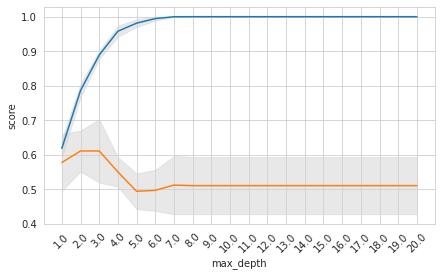

In [ ]:
name = 'max_depth'
value_range = np.linspace(1, 20, 20, endpoint=True)

## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=3,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

matplotlib.rcParams['figure.figsize'] = [7, 4]
my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name)


### Ya que vamos a explorar bastante, les dejo un atajo empaquetándoles esta función que le pasan:
* pipe: el pipeline
* hyp: el nombre del hyperparámetro que quieren mirar
* range: el rango donde quieren mirar


In [ ]:
def univariate_exploring(pipe,hyp, range,cv = 3):
  ## defino grilla
  gridname = 'clasificador__%s'%hyp
  param_grid = [
    {gridname:range}
  ]

  search = GridSearchCV(pipeline, param_grid, 
                        cv=cv,return_train_score = True,
                      scoring = 'average_precision').fit(X_train, Y_train)

  plot = my_train_test_plot(gridsearch=search,grid=param_grid,hyp=hyp)
  return(plot)

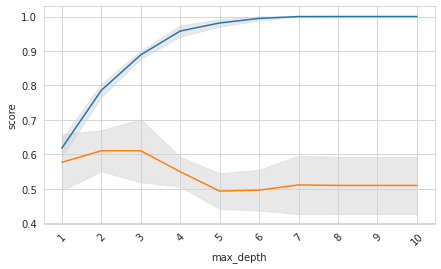

In [ ]:
# la usamos así de fácil
univariate_exploring(pipeline,'max_depth',range = [1,2,3,4,5,6,7,8,9,10],cv = 3)

### Veamos el efecto que tiene el threshold que fijamos a uno nodo (en número de muestras) para que pueda ser dividido (Min samples split)

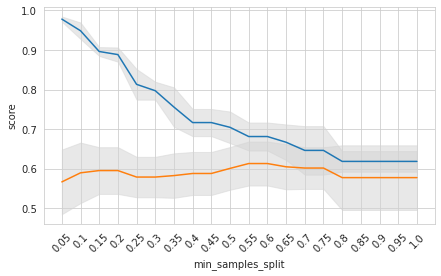

In [ ]:
univariate_exploring(pipeline,'min_samples_split',range = np.linspace(0.05, 1.0, 20, endpoint=True))

### GridSearch

In [ ]:
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',DecisionTreeClassifier(random_state = SEED))]) 
#np.logspacee(0.01, 0.2, num = 5)
max_depths = np.linspace(3, 7, 5, endpoint=True)
min_samples_splits = np.linspace(0.05, 0.2, 5, endpoint=True)
max_features= np.linspace(0.15, 0.6, 5, endpoint=True)
min_samples_leafs = np.linspace(0.01, 0.2, 5, endpoint=True)
#min_impurity_decrease = np.linspace(0,0.01, 5, endpoint=True)

param_grid = [
  {
      'clasificador__max_depth':max_depths,
      'clasificador__min_samples_split':min_samples_splits,
      'clasificador__max_features':max_features,
      'clasificador__min_samples_leaf':min_samples_leafs
#      'clasificador__min_impurity_decrease':min_impurity_decrease
  }
 ]
search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

#jlb.dump(search, 'DecisionTree.pkl')
#my_train_test_plot(search,param_grid,'min_samples_leaf')

In [ ]:
print('performance best classif %.4f'%search.best_score_)
print('best hyperparameters: \n')

search.best_params_

performance best classif 0.7550
best hyperparameters: 



{'clasificador__max_depth': 5.0,
 'clasificador__max_features': 0.6,
 'clasificador__min_samples_leaf': 0.0575,
 'clasificador__min_samples_split': 0.2}

In [ ]:
## para ver la varianza que tuvo tengo que volver a entrenar via Kfold
aux= cross_val_score(search.best_estimator_, X_train, Y_train, cv=5,scoring = 'average_precision')
print(np.mean(aux),np.std(aux))

0.7549549829529387 0.09010981801203839


In [ ]:
# en el test? 
metrics.average_precision_score(Y_test,search.best_estimator_.predict_proba(X_test)[:,1])

0.6927384386127299

### Veamos, movimos 4 hyperparámetros, en 5 puntos cada uno. Osea corrimos 5^4 = 625 iteraciones (x 5 si considerás el 5FoldValid)! 
*  Estamos invirtiendo bien el tiempo de entrenamiento? 
*  Qué otra forma un poco más inteligente podemos usar para explorar?
*  Si nos movemos random? por la grilla? o random en los intervalos de búsqueda planteados?

### Skit optimize

*   Elemento de lista
*   Elemento de lista


**Github** de  __[skit-optimize](https://scikit-optimize.github.io/stable/)__

#### Skit optimize.

In [ ]:
folds = 5; Nsteps = 50; njobs = 2

In [ ]:
max_depths = Integer(3,7, prior='uniform')
min_samples_splits = Real(5e-2, 2e-1, prior='log-uniform')
max_features= Real(0.15, 0.6, prior='uniform') 
min_samples_leafs = Real(1e-2, 2e-1, prior='log-uniform')
#min_impurity_decrease = Real(1e-5, 1e-1, prior='log-uniform')

param_grid = [
  {
      'clasificador__max_depth':max_depths,
      'clasificador__min_samples_split':min_samples_splits,
      'clasificador__max_features':max_features,
      'clasificador__min_samples_leaf':min_samples_leafs
#      'clasificador__min_impurity_decrease':min_impurity_decrease
  }
 ]

opt = BayesSearchCV(
    estimator = pipeline,
    search_spaces = param_grid,
    n_iter = Nsteps,
    random_state = SEED,
    scoring='average_precision',
    cv=folds,
    return_train_score=True,
    n_jobs=njobs)

# Fit 
opt = opt.fit(X_train, Y_train)

In [ ]:
print(opt.best_score_)
opt.best_params_

0.753264738564758


OrderedDict([('clasificador__max_depth', 4),
             ('clasificador__max_features', 0.5475741229947867),
             ('clasificador__min_samples_leaf', 0.025764129808282434),
             ('clasificador__min_samples_split', 0.052944915650922714)])

In [ ]:
## para ver la varianza que tuvo tengo que volver a entrenar via Kfold
auxopt= cross_val_score(opt.best_estimator_, X_train, Y_train, cv=5,scoring = 'average_precision')
print(np.mean(auxopt),np.std(auxopt))
# en el test? 
metrics.average_precision_score(Y_test,opt.best_estimator_.predict_proba(X_test)[:,1])

0.753264738564758 0.11599925504650262


0.7263687517193709

# Bayesian Optimization

In [ ]:
### Hagamos ahora la optimización vía gp_minimize


## Sólo cambio la forma en que llamé al clasificador.
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('m',DecisionTreeClassifier(random_state = SEED))])    


### En esta version el espacio de búsqueda lo tengo que definir acorde a skit-optimize
search_space  = [Integer(3, 7, name='m__max_depth'),
          Real(5e-2, 2e-1, "log-uniform", name='m__min_samples_split'),
          Real(0.15, 0.6, "uniform", name='m__max_features'),
          Real(1e-2, 2e-1, "log-uniform", name='m__min_samples_leaf')]
#          Categorical(['random','best'], name='m__splitter'),
#          Categorical(['entropy','gini'], name='m__criterion')]

@use_named_args(search_space)
def objective(**params):
    pipeline.set_params(**params)

    return 1.0 - np.mean(cross_val_score(pipeline, X_train, Y_train, cv=5, n_jobs=-1,
                                    scoring = 'average_precision'))




In [ ]:
?gp_minimize

In [ ]:
res_gp = gp_minimize(objective, search_space, n_calls=50, random_state=SEED)

In [ ]:
1- res_gp.fun


0.7720476727612361

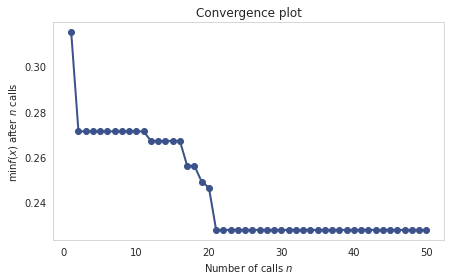

In [ ]:
skplots.plot_convergence(res_gp)

In [ ]:
print("""Best parameters:
- max_depth=%d
- min_samples_split=%.6f
- max_features=%.2f
- min_samples_leaf=%.6f
""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3]))



Best parameters:
- max_depth=7
- min_samples_split=0.050000
- max_features=0.60
- min_samples_leaf=0.070554



## Performance en evaluation set




In [ ]:
pipeline.named_steps['m'].set_params(**{
    'max_depth':res_gp.x[0],
  'min_samples_split':res_gp.x[1],
  'max_features':res_gp.x[2],
  'min_samples_leaf':res_gp.x[3]})


### Reporto varianza en el training test. 
print(np.mean(cross_val_score(pipeline, X_train, Y_train, cv=5, n_jobs=-1,
                                    scoring = 'average_precision')) )
print(np.std(cross_val_score(pipeline, X_train, Y_train, cv=5, n_jobs=-1,
                                    scoring = 'average_precision')))



0.7720476727612361
0.1064990248335496


### Performance sobre el testing set

In [ ]:
# testing performance
pipeline.fit(X_train,Y_train)
metrics.average_precision_score(Y_test,pipeline.predict_proba(X_test)[:,1])

0.7300550614253523

* logramos algo que no es trivial: Tunear un Decision Tree con pocos datos y  SIN SOBREAJUSTAR

## Acá viene lo potente:
* puedo explorar el proceso de optimización. 
* Puedo ver dependencias parciales entre hiperparámetros
* Puedo ver si me quedé corto con el rango de  exploración de alguno de ellos
* Ojo con aumentar mucho el rango de exploración de los hyp. y escatimar con el número de calls porque podés caer en un modelo subópimo (piensen que los rangos de búsqueda los definimos habiendo explorado cada hyper individualmente, es decir una solución de orden cero que no considera interacciones de mayor orden).

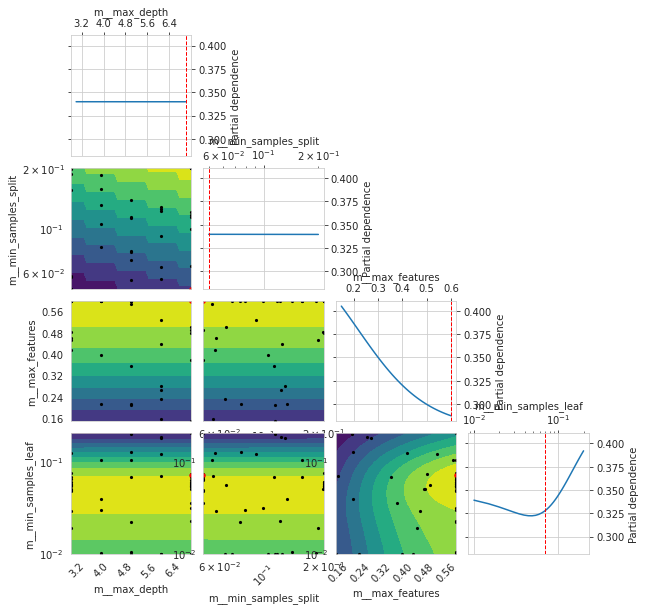

In [ ]:
_ = skplots.plot_objective(res_gp)

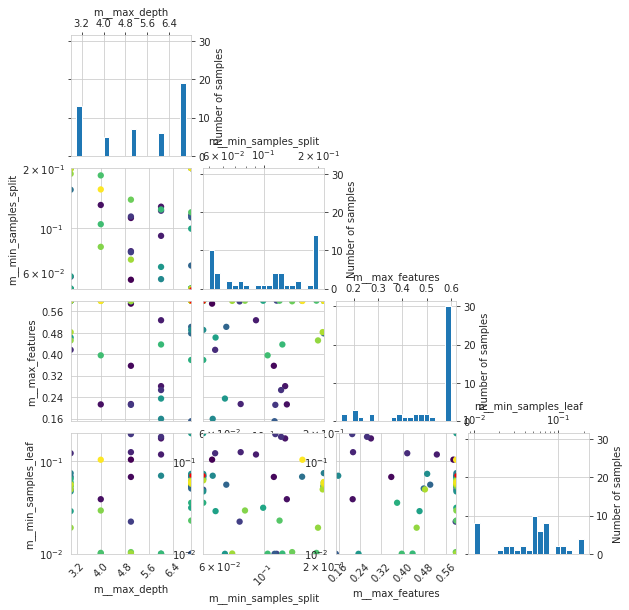

In [ ]:
_ = skplots.plot_evaluations(res_gp)

## Ganando insights sobre cómo está funcionando nuestro modelo

* Vamos a usar shap (usa teoría de juegos).
* También se puede usar Lime (usa perturvaciones y linearización), en particular para entender predicciones localmente (a nivel de ítem). 

In [ ]:
be = opt.best_estimator_
pp = be.named_steps['preprocessing']
model = be.named_steps['clasificador']

In [ ]:
Xprep = pp.transform(X_train)
Xprep = pd.DataFrame(Xprep)  # preproceso para que SHAP pueda perturbar sin nulls

# recupero nombre de columnas
numerical_names = pp.transformers_[0][2]
categorical_output_names = pp.named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()
cols = numerical_names + categorical_output_names
Xprep.columns = cols

Xtrain_sampled = shap.sample(Xprep,1000)

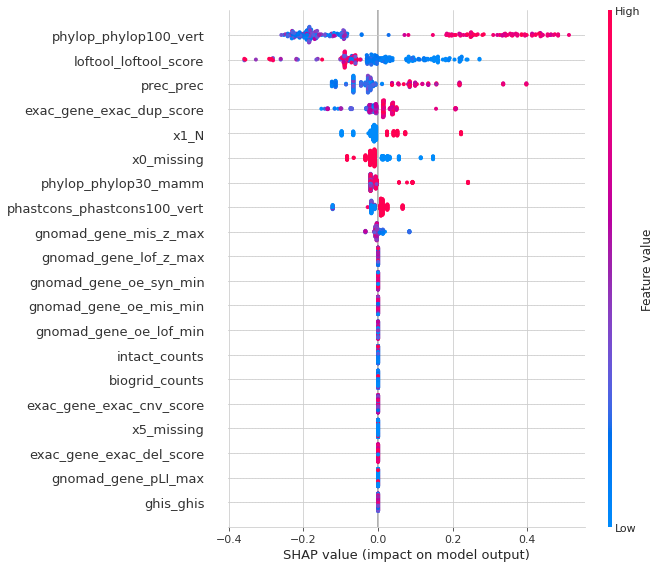

In [ ]:
shap_tree_explainer = shap.TreeExplainer(model, Xtrain_sampled,model_output = 'probability')
shap_values = shap_tree_explainer.shap_values(Xtrain_sampled)
shap.summary_plot(shap_values[1], Xtrain_sampled, plot_type="dot")

### Interaction plots 
* para entender valor predictivo conjunto de grupos de dos variables

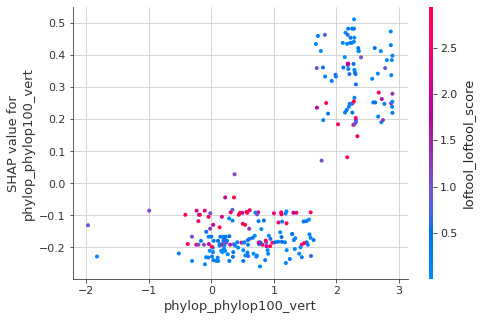

In [ ]:
shap.dependence_plot('phylop_phylop100_vert', shap_values[1], Xtrain_sampled)

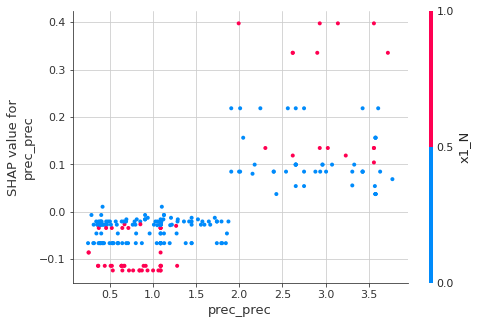

In [ ]:
shap.dependence_plot("rank(2)",shap_values[1], Xtrain_sampled)

#### Podes ver dependencias parciales entre los features que quieras.

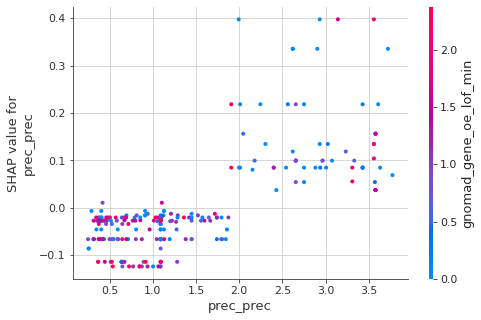

In [ ]:
shap.dependence_plot(ind = "rank(2)",shap_values = shap_values[1], features = Xtrain_sampled,interaction_index = "gnomad_gene_oe_lof_min")

#### Que pasa cuando los features están muy correlacionados entre sí?

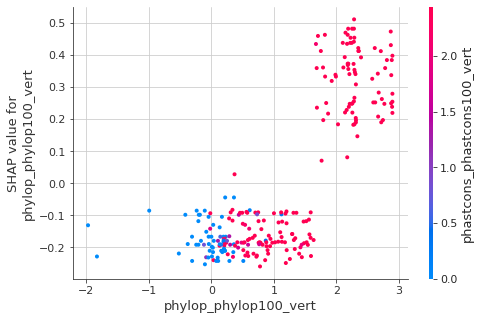

In [ ]:
shap.dependence_plot(ind = 'phylop_phylop100_vert',shap_values = shap_values[1], 
                     features = Xtrain_sampled,interaction_index = 'phastcons_phastcons100_vert')

### Explicando predicciones localmente (a nivel de ítem individual)
*  Les dejo el código nomás (ojo q es costoso en cálculo)

In [ ]:
## predicciones 
#X_output = pd.DataFrame(pp.transform(X_test))
#X_output.columns = cols
#X_output.loc[:,'predict'] = np.round(model.predict_proba(X_output),2)

# Randomly pick some observations
#random_picks = np.arange(1,250,10) # Every 50 rows
#S = X_output.iloc[random_picks]
#ii =S.index



#def shap_plot(j):
#    explainerModel = shap.TreeExplainer(model,S)
#    shap_values_Model = explainerModel.shap_values(S)
#    p = shap.force_plot(explainerModel.expected_value[1], shap_values_Model[1][j],S.iloc[[j]])
#    return(p)

In [ ]:
#shap.initjs()
#localplot = shap_plot(ii[2])
#localplot